<a href="https://colab.research.google.com/github/o93/bayesian-ab/blob/main/BeyesianAB__Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 32.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=f984b4c96b172fea1de3c6cceeb2fc1a702875fef44e27d58080d466db181ec3
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


以下でベイジアンABテストを実行します


,imp_count,cv_count
name,,
b,27151,414
a,26830,469


Output()

Output()

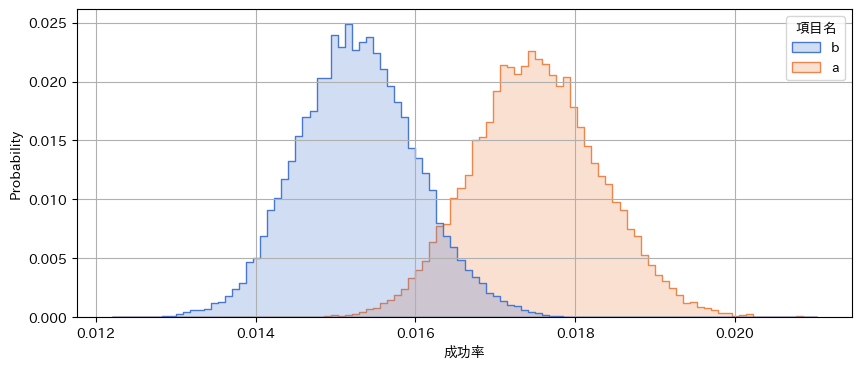

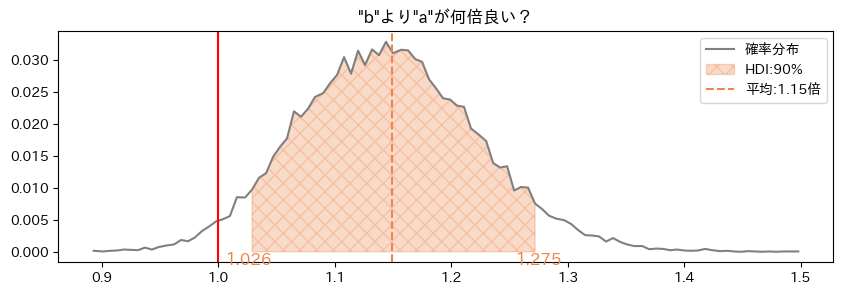

In [ ]:
import dataclasses

import pymc as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import numpy as np
import pandas as pd


#@markdown テストパターン 1
p1_name = "b" # @param {type:"string"}
p1_imp = 27151  # @param {type:"integer"}
p1_cv = 414    # @param {type:"integer"}
#@markdown テストパターン 2
p2_name = "a" # @param {type:"string"}
p2_imp = 26830  # @param {type:"integer"}
p2_cv = 469    # @param {type:"integer"}
#@markdown テストパターン 3
p3_name = "" # @param {type:"string"}
p3_imp = 0  # @param {type:"integer"}
p3_cv = 0    # @param {type:"integer"}
#@markdown テストパターン 4
p4_name = "" # @param {type:"string"}
p4_imp = 0   # @param {type:"integer"}
p4_cv = 0    # @param {type:"integer"}
#@markdown 判定のしきい値（デフォルト: 90%）
threshold = 0.9 # @param {type:"slider", min:0.0, max:1.0, step:0.01}
#@markdown サンプル数（デフォルト: 10000）
sample_size = 10000 # @param {type: "integer"}

aggs = pd.DataFrame([
    [p1_name, p1_imp, p1_cv],
    [p2_name, p2_imp, p2_cv],
    [p3_name, p3_imp, p3_cv],
    [p4_name, p4_imp, p4_cv],
], columns=['name', 'imp_count', 'cv_count'])
aggs = aggs[aggs['imp_count'] > 0]
aggs.set_index('name', inplace=True)
print('以下でベイジアンABテストを実行します')
display(aggs)

@dataclasses.dataclass
class Pattern:
    name: str
    alpha: float
    beta: float
    trials: int
    successes: int

@dataclasses.dataclass
class Comb:
    key: str
    challenger: int
    champion: int

def convert_params(params):
    param_size = 5
    all_size = len(params)
    pattern_size = all_size // param_size
    pattern_param_size = pattern_size * param_size

    patterns = []
    for i in range(0, pattern_param_size, param_size):
        if params[i] == '':
            break
        p = params[i:i + param_size]
        patterns.append(Pattern(*p))

    threshold = params[pattern_param_size]
    sample_size = int(params[pattern_param_size + 1])

    return patterns, threshold, sample_size

def make_trace(patterns, threshold, sample_size):
    pattern_size = len(patterns)

    combs = {
        2: [Comb('1_0', 1, 0)],
        3: [Comb('1_0', 1, 0), Comb('2_0', 2, 0), Comb('2_1', 2, 1)],
        4: [
            Comb('1_0', 1, 0), Comb('2_0', 2, 0), Comb('3_0', 3, 0),
            Comb('2_1', 2, 1), Comb('3_1', 3, 1), Comb('3_2', 3, 2),
        ],
    }[pattern_size]

    with pm.Model() as model:
        # 事前分布
        p = pm.Beta(
                    'p',
                    alpha=[p.alpha for p in patterns],
                    beta=[p.beta for p in patterns],
                    shape=pattern_size,
        )
        # 事後分布
        obs = pm.Binomial(
                    'y',
                    n=[p.trials for p in patterns],
                    observed=[p.successes for p in patterns],
                    p=p,
                    shape=pattern_size,
        )
        for c in combs:
            pm.Deterministic(c.key, p[c.challenger] / p[c.champion])

        return pm.sample(draws=sample_size), combs

def plot_probs(patterns, trace, threshold, sample_size):
    pattern_size = len(patterns)
    v = trace.posterior['p'].values
    samples = pd.DataFrame(
        v.reshape((v.shape[0] * v.shape[1], v.shape[2])),
        columns=[p.name for p in patterns],
    )
    samples = samples.stack().to_frame()
    samples.reset_index(level=1, inplace=True)
    samples.columns = ['項目名', '成功率']

    colors = sns.color_palette('muted')

    plt.figure(figsize=(10, 4))
    sns.histplot(
                data=samples, x='成功率', hue='項目名',
                bins=100,
                stat='probability', element='step', palette=colors[:pattern_size],
    )
    plt.grid(True)
    plt.show()

def plot_combs(patterns, trace, combs, threshold, sample_size):
    comb_size = len(combs)
    colors = sns.color_palette('muted')

    if comb_size > 1:
        fig, axes = plt.subplots(comb_size, 1, figsize=(10, comb_size * 3))
    else:
        fig, ax = plt.subplots(comb_size, 1, figsize=(10, comb_size * 3))
        axes = [ax]

    for i, c in enumerate(combs):
        name = f'"{patterns[c.champion].name}"より"{patterns[c.challenger].name}"が何倍良い？'
        v = trace.posterior[c.key].values
        samples = pd.DataFrame(
            v.reshape((v.shape[0] * v.shape[1])),
            columns=[name],
        )

        counts = samples[name].value_counts(bins=100, sort=False)
        counts.index = counts.index.left
        rates = counts.to_frame()
        rates['count'] = rates['count'] / rates['count'].sum()

        ax = axes[i]
        ax.plot(rates, color='gray', label='確率分布')
        ax.set_facecolor((1, 1, 1, 1))

        hdi = az.hdi(samples[name].values, hdi_prob=threshold)
        index = rates['count'].index
        region = (hdi[0] < index) & (index < hdi[1])
        color = colors[c.challenger]

        ax.fill_between(
            index[region], rates['count'][region], 0, alpha=0.3,
            color=color, hatch='xx', label=f'HDI:{threshold * 100:.0f}%',
        )
        ax.axvline(
            x=samples[name].mean(), color=color,
            label=f'平均:{samples[name].mean():.2f}倍', linestyle='dashed',
        )
        ax.axvline(x=1.0, color='red')
        ax.text(hdi[0], 0, f'{hdi[0]:.3f}', ha='center', va='top', color=color, size='large')
        ax.text(hdi[1], 0, f'{hdi[1]:.3f}', ha='center', va='top', color=color, size='large')
        ax.grid(False)
        ax.legend()
        ax.set_title(name)

params = []
for type, row in aggs.iterrows():
    params.append(type)
    params.extend([1.0, 1.0])
    params.append(np.round(row['imp_count']))
    params.append(np.round(row['cv_count']))
params.append(threshold)
params.append(sample_size)

# 各種パラメータ取得
patterns, threshold, sample_size = convert_params(params)

# ベイジアンモデル
trace, combs = make_trace(patterns, threshold, sample_size)

# 描画
plot_probs(patterns, trace, threshold, sample_size)
plot_combs(patterns, trace, combs, threshold, sample_size)